<a href="https://colab.research.google.com/github/cprejler/pytexamproject/blob/main/pytexamproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#4 Semester Python Eksamens Projekt

#Tough Sympathy - Mikkel Skott Lind, Casper Prejler, Aske Thorsen

import requests
import numpy as np
import pandas as pd
from google.colab import drive 
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from sklearn.model_selection import train_test_split
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install

! git lfs clone https://github.com/Malthorn1/PythonExamnFiles

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.13.1).
0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded.
Git LFS initialized.
          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'PythonExamnFiles'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 0), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), 

### I vores eksamensprojekt har vi lavet 2 modeller på samme dataset. Vi har lavet en stor model, som tager alle personlighedstyperne med, samt en lille model, som kun sammenligner på om en person er E-Ekstrovert eller I-Introvert. Vi vil på den måde se hvor stor en forskel der er på accuracy, i de forskellige tilfælde.

### Vores hypotese er, at vi vil få en meget højere accuracy på den lille model, grundet størrelsen på vores dataset. Samt at vi har alt for lidt data på ekstroverte


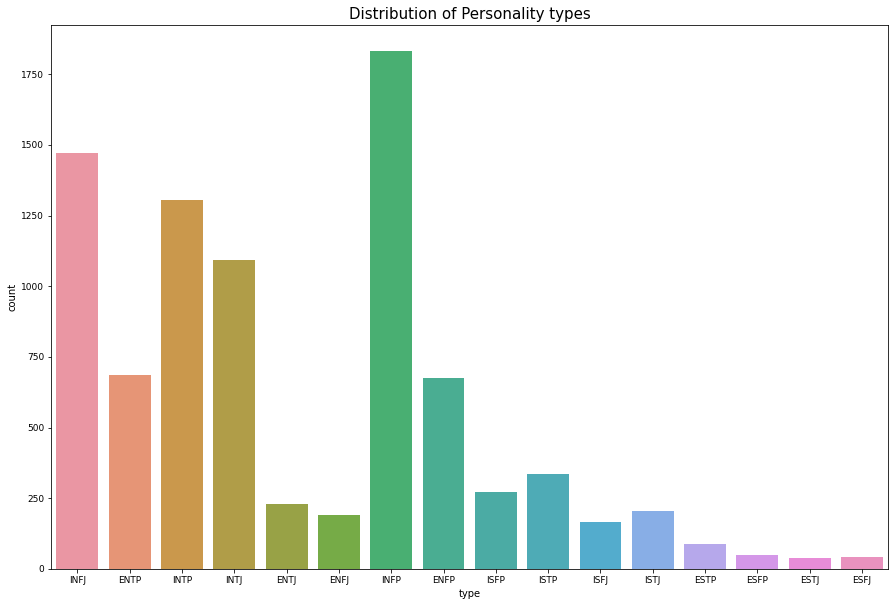

In [19]:
data = pd.read_csv('/content/PythonExamnFiles/mbti_1.csv')

plt.figure(figsize=(15,10))
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0)
plt.title('Distribution of Personality types', fontsize=15)
sns.countplot(data=data, x='type')

### Vi kan se i grafen ovenfor fordelingen på de forskellige personlighedstyper. Som vi kan se, er der en stor mængde introverte i forhold til ekstroverte. 

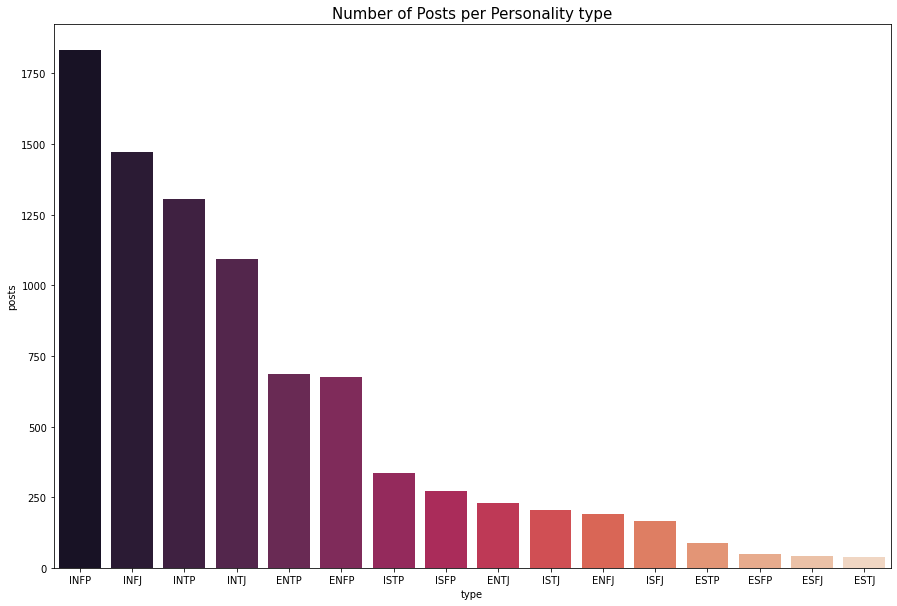

In [20]:
data = pd.read_csv('/content/PythonExamnFiles/mbti_1.csv')


gr = data.groupby('type').count()
gr.sort_values("posts", ascending=False, inplace=True)


plt.figure(figsize=(15,10))
sns.barplot(x=gr.index,y='posts',data=gr,palette='rocket')
plt.title('Number of Posts per Personality type',fontsize=15)
plt.show()


### I grafen ovenfor kan vi se hvor mange posts vi har per personlighestype. Igen kan vi se at introverte har den største mængde træningsdata.  

In [ ]:

data = pd.read_csv('/content/PythonExamnFiles/mbti_1.csv)


#Process text

def big_model(df):
    
    texts = df['posts'].copy()
    labels = df['type'].copy()
    #Stopwords fjerner irrelevante ord som 'is', 'are' 'the'
    stop_words = stopwords.words('english')
    #Filterring af alle posts til en liste af ord.
    texts = [text.lower() for text in texts]
    texts =  [text.split() for text in texts]
    texts = [[word.strip() for word in text] for text in texts]
    texts = [[word for word in text if word not in stop_words] for text in texts]
    
    #Rank liste over tit de bliver nævnt. Lavere er højest.
    vocab_length = 10000
    
    tokenizer = Tokenizer(num_words=vocab_length)
    tokenizer.fit_on_texts(texts)
    
    texts = tokenizer.texts_to_sequences(texts)
    
    max_seq_length = np.max([len(text) for text in texts])
    
    texts = pad_sequences(texts, maxlen=max_seq_length, padding='post')

    #Map typerne til tal fra 0-15
    types = np.unique(df.type.values)

    def get_type_index(string):
      return list(types).index(string)

    df['type_index'] = df['type'].apply(get_type_index)


    #Transformerer dataen til binær efter om det er introvert eller ekstrovert 
    labels = tf.keras.utils.to_categorical(df['type_index'].values, num_classes=16)
    
    #labels = np.array(label_values)
    
    return texts, labels, max_seq_length, vocab_length
    

texts, labels, max_seq_length, vocab_length = big_model(data)


print("Text sequences:n", texts.shape)
print("\nLabels:\n", labels.shape)
print("\nMax sequence length:\n", max_seq_length)
print("\nVocab length\n" , vocab_length)





texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, train_size=0.7, random_state=123)
texts

embedding_dim = 512


inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(inputs)


gru = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(
        units=256,
        return_sequences=True
    )
)(embedding)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(16, activation='softmax')(flatten)


model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)


history = model.fit(
    texts_train,
    labels_train,
    validation_split=0.2,
    batch_size=32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('/home/big_model.h5', save_best_only=True, save_weights_only=True)
    ]
)

model.save('/home/big_final_model.h5')

numpyhistory = np.array(history.history)
np.save("/home/big_model_history.npy", numpyhistory)


Text sequences:n (8675, 859)

Labels:
 (8675, 16)

Max sequence length:
 859

Vocab length
 10000
Epoch 1/5
152/152 [==============================] - 1371s 9s/step - loss: 2.5044 - accuracy: 0.1921 - auc: 0.7547 - val_loss: 1.9461 - val_accuracy: 0.3942 - val_auc: 0.8604
Epoch 2/5
152/152 [==============================] - 1371s 9s/step - loss: 0.1121 - accuracy: 0.9798 - auc: 0.9998 - val_loss: 1.8671 - val_accuracy: 0.4189 - val_auc: 0.8672
Epoch 3/5
152/152 [==============================] - 1375s 9s/step - loss: 0.0091 - accuracy: 0.9997 - auc: 1.0000 - val_loss: 1.9309 - val_accuracy: 0.4420 - val_auc: 0.8651
Epoch 4/5
152/152 [==============================] - 1375s 9s/step - loss: 0.0039 - accuracy: 0.9998 - auc: 1.0000 - val_loss: 1.9422 - val_accuracy: 0.4412 - val_auc: 0.8638
Epoch 5/5
152/152 [==============================] - 1370s 9s/step - loss: 0.0032 - accuracy: 0.9998 - auc: 1.0000 - val_loss: 2.0594 - val_accuracy: 0.4444 - val_auc: 0.8584


loss : [2.2002429962158203, 0.09955437481403351, 0.009557889774441719, 0.004407041240483522, 0.003124210052192211]
accuracy : [0.2868025600910187, 0.9831171631813049, 0.9991764426231384, 0.9993823170661926, 0.9995882511138916]
auc : [0.8096981048583984, 0.9998317956924438, 0.9999997019767761, 0.9999999403953552, 0.9999998807907104]
val_loss : [1.9461389780044556, 1.8670936822891235, 1.9308569431304932, 1.9422060251235962, 2.059380531311035]
val_accuracy : [0.39423868060112, 0.4189300537109375, 0.44197529554367065, 0.44115227460861206, 0.4444444477558136]
val_auc : [0.8603784441947937, 0.8671704530715942, 0.8650896549224854, 0.8638384342193604, 0.8584461212158203]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 859)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 859, 512)    

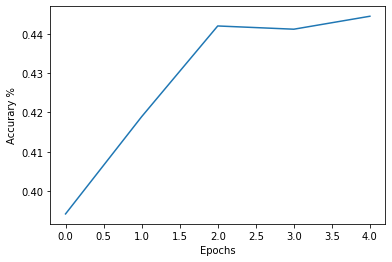

In [55]:
big_model_history = np.load('/content/PythonExamnFiles/big_model_history.npy', allow_pickle=True)

history = big_model_history.tolist()

for item, value in history.items():
    print(item + ' : ' + str(value))


model = tf.keras.models.load_model('/content/PythonExamnFiles/big_final_model.h5')



print(model.summary())


plt.plot(history['val_accuracy'])
plt.ylabel('Accurary %')
plt.xlabel('Epochs')
plt.show()

In [ ]:
data = pd.read_csv('/content/PythonExamnFiles/mbti_1.csv')


#Process text

def small_model(df):
    
    texts = df['posts'].copy()
    labels = df['type'].copy()
    #Stopwords fjerner irrelevante ord som 'is', 'are' 'the'
    stop_words = stopwords.words('english')
    #Filterring af alle posts til en liste af ord.
    texts = [text.lower() for text in texts]
    texts =  [text.split() for text in texts]
    texts = [[word.strip() for word in text] for text in texts]
    texts = [[word for word in text if word not in stop_words] for text in texts]
    
    #Rank liste over tit de bliver nævnt. Lavere er højest.
    vocab_length = 10000
    
    tokenizer = Tokenizer(num_words=vocab_length)
    tokenizer.fit_on_texts(texts)
    
    texts = tokenizer.texts_to_sequences(texts)
    
    max_seq_length = np.max([len(text) for text in texts])
    
    texts = pad_sequences(texts, maxlen=max_seq_length, padding='post')
    
    label_values = {
        'INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ','INFP', 'ENFP',
        'ISTP', 'ISFP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'
    }
    #Transformerer dataen til binær efter om det er introvert eller ekstrovert 
    label_mapping = {label: np.int(label[0] == 'E') for label in label_values}
    labels = labels.replace(label_mapping)
    labels = np.array(labels)
    
    return texts, labels, max_seq_length, vocab_length, label_mapping
    

texts, labels, max_seq_length, vocab_length, label_mapping = small_model(data)


print("Text sequences:n", texts.shape)
print("\nLabels:\n", labels.shape)
print("\nMax sequence length:\n", max_seq_length)
print("\nVocab length\n" , vocab_length)
print("\nLabel Mapping\n" , label_mapping)




texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, train_size=0.7, random_state=123)
texts

embedding_dim = 512


inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(inputs)


gru = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(
        units=256,
        return_sequences=True
    )
)(embedding)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)


model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)


history = model.fit(
    texts_train,
    labels_train,
    validation_split=0.2,
    batch_size=32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('/home/model.h5', save_best_only=True, save_weights_only=True)
    ]
)

model.save('/home/small_final_model.h5')



numpy_history = np.array(history.history)
np.save("/home/small_model_history.npy", numpy_history)





Text sequences:n (8675, 859)

Labels:
 (8675,)

Max sequence length:
 859

Vocab length
 10000

Label Mapping
 {'ESFP': 1, 'ISTJ': 0, 'INFJ': 0, 'INTP': 0, 'ENFJ': 1, 'ISFP': 0, 'ESTJ': 1, 'ISTP': 0, 'INFP': 0, 'ESTP': 1, 'ISFJ': 0, 'ENFP': 1, 'ENTJ': 1, 'INTJ': 0, 'ENTP': 1, 'ESFJ': 1}
Epoch 1/5
 19/152 [==>...........................] - ETA: 18:42 - loss: 0.7046 - accuracy: 0.6175 - auc: 0.4942

In [ ]:


model = tf.keras.models.load_model('/content/PythonExamnFiles/Smallfinal_model.h5')

print(model.summary())



Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 859)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 859, 512)          5120000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 859, 512)          1182720   
_________________________________________________________________
flatten_7 (Flatten)          (None, 439808)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 439809    
Total params: 6,742,529
Trainable params: 6,742,529
Non-trainable params: 0
_________________________________________________________________
None
